In [1]:
import requests
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
html = HTMLSession().get('https://finance.yahoo.com/quote/AAPL/history?p=AAPL')

In [3]:
soup = BeautifulSoup(html.content,'lxml')

In [4]:
data_table = soup.find_all('table',class_='W(100%) M(0)')[0]

In [5]:
columns_table = data_table.find('tr',class_='C($tertiaryColor) Fz(xs) Ta(end)')

In [6]:
columns = columns_table.find_all('th')

In [7]:
columns_names = []
for column in columns:
    columns_names.append(column.find('span').text.strip())

In [8]:
columns_names

['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']

In [9]:
all_data = data_table.find_all('tr',class_='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')

In [10]:
data = []

In [11]:
for i in range(len(all_data)):
    numbers = all_data[i].find_all('span')
    data.append({})
    for j in range(len(columns_names)):
        if len(numbers) < 7:
            continue
        data[i][columns_names[j]] = numbers[j].text.strip()

In [12]:
data

[{'Date': 'Mar 21, 2024',
  'Open': '177.05',
  'High': '177.49',
  'Low': '170.84',
  'Close*': '171.37',
  'Adj Close**': '171.37',
  'Volume': '105,906,200'},
 {'Date': 'Mar 20, 2024',
  'Open': '175.72',
  'High': '178.67',
  'Low': '175.09',
  'Close*': '178.67',
  'Adj Close**': '178.67',
  'Volume': '53,423,100'},
 {'Date': 'Mar 19, 2024',
  'Open': '174.34',
  'High': '176.61',
  'Low': '173.03',
  'Close*': '176.08',
  'Adj Close**': '176.08',
  'Volume': '55,215,200'},
 {'Date': 'Mar 18, 2024',
  'Open': '175.57',
  'High': '177.71',
  'Low': '173.52',
  'Close*': '173.72',
  'Adj Close**': '173.72',
  'Volume': '75,604,200'},
 {'Date': 'Mar 15, 2024',
  'Open': '171.17',
  'High': '172.62',
  'Low': '170.29',
  'Close*': '172.62',
  'Adj Close**': '172.62',
  'Volume': '121,664,700'},
 {'Date': 'Mar 14, 2024',
  'Open': '172.91',
  'High': '174.31',
  'Low': '172.05',
  'Close*': '173.00',
  'Adj Close**': '173.00',
  'Volume': '72,913,500'},
 {'Date': 'Mar 13, 2024',
  'Ope

In [13]:
df = pd.DataFrame(data,columns=columns_names)

In [14]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Mar 21, 2024",177.05,177.49,170.84,171.37,171.37,"105,906,200"
1,"Mar 20, 2024",175.72,178.67,175.09,178.67,178.67,"53,423,100"
2,"Mar 19, 2024",174.34,176.61,173.03,176.08,176.08,"55,215,200"
3,"Mar 18, 2024",175.57,177.71,173.52,173.72,173.72,"75,604,200"
4,"Mar 15, 2024",171.17,172.62,170.29,172.62,172.62,"121,664,700"


In [15]:
df.isna().sum()

Date           2
Open           2
High           2
Low            2
Close*         2
Adj Close**    2
Volume         2
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.isna().sum()

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         98 non-null     object
 1   Open         98 non-null     object
 2   High         98 non-null     object
 3   Low          98 non-null     object
 4   Close*       98 non-null     object
 5   Adj Close**  98 non-null     object
 6   Volume       98 non-null     object
dtypes: object(7)
memory usage: 6.1+ KB


In [20]:
df['Date'] = pd.to_datetime(df['Date'])

In [21]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2024-03-21,177.05,177.49,170.84,171.37,171.37,"105,906,200"
1,2024-03-20,175.72,178.67,175.09,178.67,178.67,"53,423,100"
2,2024-03-19,174.34,176.61,173.03,176.08,176.08,"55,215,200"
3,2024-03-18,175.57,177.71,173.52,173.72,173.72,"75,604,200"
4,2024-03-15,171.17,172.62,170.29,172.62,172.62,"121,664,700"


In [22]:
numerical_cols = ['Open','High', 'Low', 'Close*', 'Adj Close**', 'Volume']
df[numerical_cols]=df[numerical_cols].replace(',', '', regex=True).astype(float)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         98 non-null     datetime64[ns]
 1   Open         98 non-null     float64       
 2   High         98 non-null     float64       
 3   Low          98 non-null     float64       
 4   Close*       98 non-null     float64       
 5   Adj Close**  98 non-null     float64       
 6   Volume       98 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.1 KB


In [24]:
df = df.set_index('Date')
df.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2024-03-21,177.05,177.49,170.84,171.37,171.37,105906200.0
2024-03-20,175.72,178.67,175.09,178.67,178.67,53423100.0
2024-03-19,174.34,176.61,173.03,176.08,176.08,55215200.0
2024-03-18,175.57,177.71,173.52,173.72,173.72,75604200.0
2024-03-15,171.17,172.62,170.29,172.62,172.62,121664700.0


In [25]:
sns.set_style('darkgrid')
plt.style.use("ggplot")

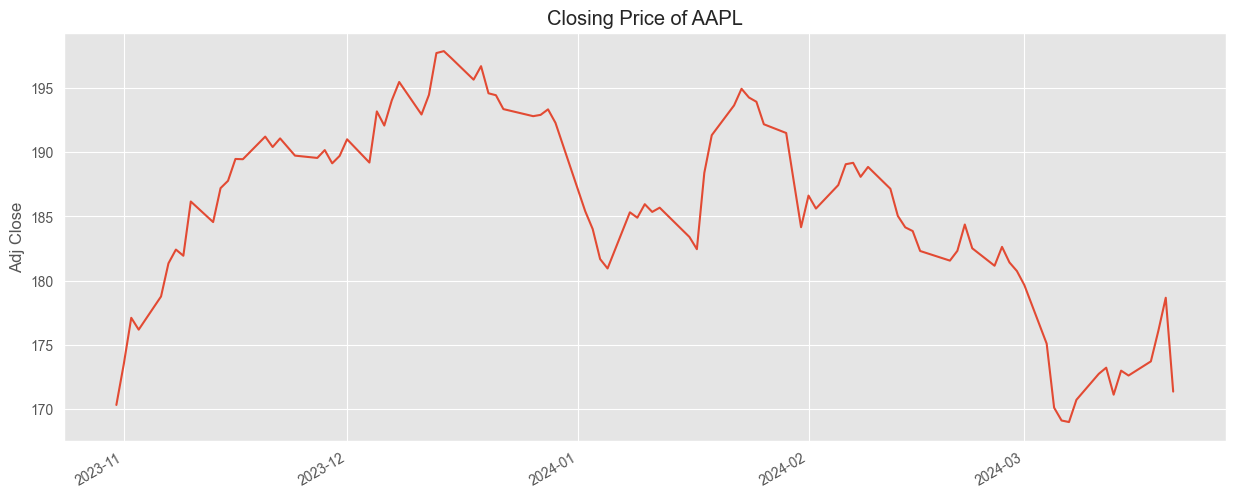

In [26]:
plt.figure(figsize=(15, 6))
df['Adj Close**'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title('Closing Price of AAPL')
plt.show()

In [27]:
X = df.drop('Adj Close**',axis=1)
y = df['Adj Close**']

In [28]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [29]:
tscv = TimeSeriesSplit(n_splits=10) 
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [30]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [31]:
model = Sequential([
    LSTM(64,activation='relu', return_sequences=False),
    Dense(1)
])

In [32]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
history = model.fit(X_train, y_train, epochs=500, batch_size=4)

Epoch 1/500

23/23 [==============================] - 2s 2ms/step - loss: 34691.8867
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 34610.4922
Epoch 3/500
23/23 [==============================] - 0s 1ms/step - loss: 34496.3906
Epoch 4/500
23/23 [==============================] - 0s 2ms/step - loss: 34314.4414
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 34037.1875
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 33625.8711
Epoch 7/500
23/23 [==============================] - 0s 1ms/step - loss: 33071.3633
Epoch 8/500
23/23 [==============================] - 0s 2ms/step - loss: 32341.9805
Epoch 9/500
23/23 [==============================] - 0s 2ms/step - loss: 31468.4648
Epoch 10/500
23/23 [==============================] - 0s 2ms/step - loss: 30378.0781
Epoch 11/500
23/23 [==============================] - 0s 3ms/step - loss: 29154.4160
Epoch 12/500
23/23 [==============================] - 0s 2ms/step - loss:

In [34]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 220ms/step


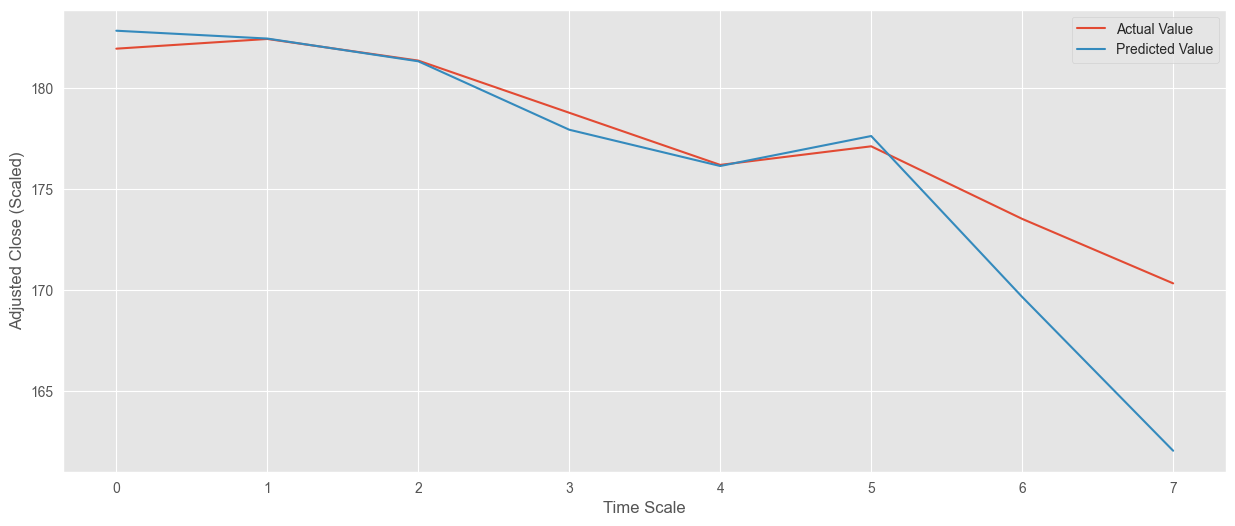

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Value')
plt.plot(y_pred, label='Predicted Value')
plt.ylabel('Adjusted Close (Scaled)')
plt.xlabel('Time Scale')
plt.legend()